# **An application of the Engle-Granger Two-Step procedure to financial time series**


### Import libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats


### Loading time series from yfinance: 

>GDX : *VanEck Gold Miners ETF*
>
>GOAU : *US Global GO GOLD and Precious Metal Miners ETF*

In [3]:
gdx_data = yf.download("GDX", start="2018-01-01", end="2023-01-01")["Adj Close"]
goau_data = yf.download("GOAU", start="2018-01-01", end="2023-01-01")["Adj Close"]

# Le code Python ci-dessus utilise la bibliothèque yfinance pour télécharger les données d'ajustement des clôtures pour deux tickers, 'GDX' et 'GOAU'. à partir de Yahoo Finance.
# Les données sont extraites pour la période allant de janvier 2018 à janvier 2023.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
data_stocks = pd.DataFrame({"GDX": gdx_data, "GOAU": goau_data})

#The line of code creates a DataFrame named 'stocks' using the pandas library, containing the time series data for the tickers 'GDX' and 'GOAU' downloaded earlier.
#Each column of the DataFrame represents the corresponding closing adjustment prices for the two assets.

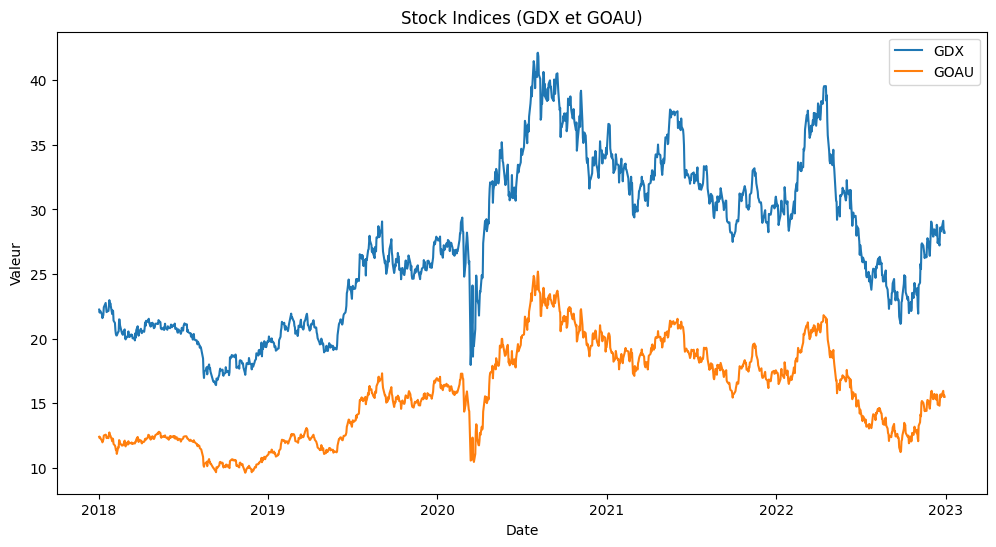

In [5]:
#plot stock indeces
plt.figure(figsize=(12, 6))
plt.plot(data_stocks["GDX"], label="GDX")
plt.plot(data_stocks["GOAU"], label="GOAU")
plt.title("Stock Indices (GDX et GOAU)")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.show()
#use Matplotlib to plot the corresponding time series. The graph displays the index values over time.

### Engle-Granger Two-Step Method

In [6]:
for stock in data_stocks.columns:
    adf_statistic, adf_pvalue, _, _, _, _ = sm.tsa.adfuller(data_stocks[stock])
    print(f"\nTest de Dickey-Fuller for {stock}:")
    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {adf_pvalue}")
    print(
        f'Result of the stationarity test: {"Stationary" if adf_pvalue < 0.05 else "Non-Stationary"}'
    )

#The code performs the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the time series 'GDX' and 'GOAU'.
#It prints the ADF statistics, p-values, and the result of the stationarity test for each series.
#Stationarity is evaluated by comparing the p-value to the threshold of 0.05, where a lower p-value indicates stationarity.


Test de Dickey-Fuller for GDX:
ADF Statistic: -1.9801315636706551
p-value: 0.29535208261923385
Result of the stationarity test: Non-Stationary

Test de Dickey-Fuller for GOAU:
ADF Statistic: -1.84849361868389
p-value: 0.35666534750253576
Result of the stationarity test: Non-Stationary


In [7]:
for stock in data_stocks.columns:
    adf_result = adfuller(data_stocks[stock].diff().dropna(), autolag="AIC")

    print(f"\nTest de Dickey-Fuller pour difference{stock}:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print(f"Critical Values: {adf_result[4]}")
    print(
        f'Result of the stationarity test: {"Stationary" if adf_result[1] < 0.05 else "Non-Stationary"}'
    )

#This code performs the Augmented Dickey-Fuller (ADF) test on differencing of the time series 'GDX' and 'GOAU'.
#It prints the ADF statistics, p-values, critical values, and the result of the stationarity test for each differenced series.
#Stationarity is evaluated by comparing the p-value to the threshold of 0.05, where a lower p-value indicates stationarity.


Test de Dickey-Fuller pour differenceGDX:
ADF Statistic: -17.922556658407466
p-value: 2.902594621975244e-30
Critical Values: {'1%': -3.4355796466416777, '5%': -2.863849421064024, '10%': -2.5679995625056926}
Result of the stationarity test: Stationary

Test de Dickey-Fuller pour differenceGOAU:
ADF Statistic: -21.70633350832285
p-value: 0.0
Critical Values: {'1%': -3.435571295403709, '5%': -2.863845736356174, '10%': -2.567997600196822}
Result of the stationarity test: Stationary


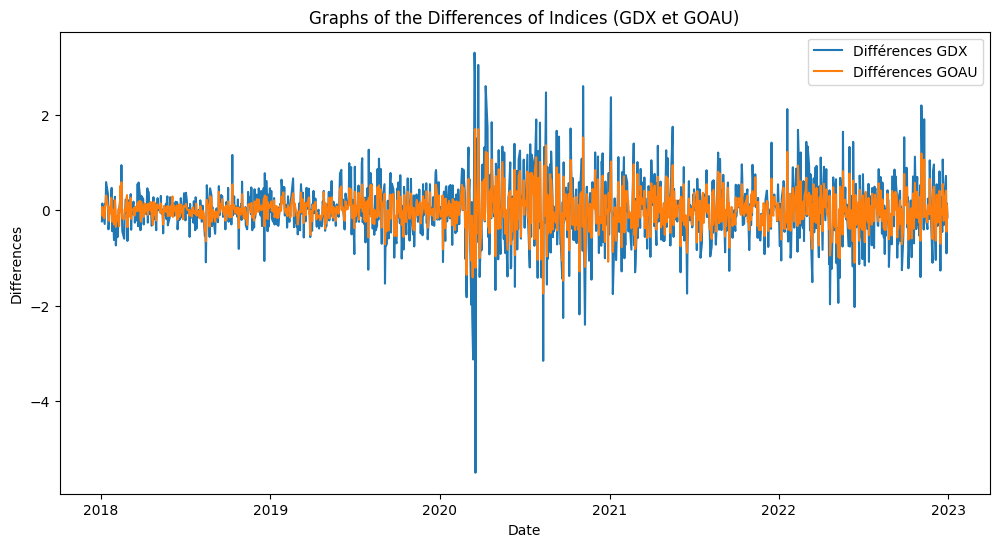

In [8]:
# Check the stationarity of the differences.
plt.figure(figsize=(12, 6))
plt.plot(data_stocks['GDX'].diff().dropna(), label='Différences GDX')
plt.plot(data_stocks['GOAU'].diff().dropna(), label='Différences GOAU')
plt.title('Graphs of the Differences of Indices (GDX et GOAU)')
plt.xlabel('Date')
plt.ylabel('Differences')
plt.legend()    
plt.show()

# This code generates a plot of the differences between the time series 'GDX' and 'GOAU'.
# Lagged differences are calculated using the diff() method, and missing values are dropped with dropna().
# The plot displays the differences over time, with labels for each series.

In [9]:
# Step 1: Linear Regression
X = sm.add_constant(data_stocks['GDX'])
model = sm.OLS(data_stocks['GOAU'], X).fit()
alpha, beta = model.params

# Calculate residuals
residuals = data_stocks['GOAU'] - alpha - beta * data_stocks['GDX']

#This code performs a simple linear regression where 'GOAU' depends on 'GDX'.
#It calculates the residuals to assess the difference between the observed values and the values predicted by the model.

In [10]:
# Step 2: Test the residuals for unit root
adf_statistic, adf_pvalue, _, _, _, _ = sm.tsa.adfuller(residuals)
print(f'ADF Statistic for Residuals: {adf_statistic}')
print(f'p-value for ADF Test: {adf_pvalue}')

# Test for cointegration
cointegration_test_result = adf_pvalue < 0.05
print(f'Cointegration Test Result: {cointegration_test_result}')

# This code performs an Augmented Dickey-Fuller (ADF) test on the residuals of the regression to assess their stationarity.
# Then, it tests for cointegration by checking if the p-value of the ADF test is less than 0.05.
# If so, the result of the cointegration test is positive, indicating a long-term relationship between the series.  

ADF Statistic for Residuals: -3.609370943703993
p-value for ADF Test: 0.005584382006611453
Cointegration Test Result: True


In [11]:
# Step 2: Creating the Error Correction Model (ECM)
df=data_stocks
df.dropna(inplace=True)
lagged_gdx = df['GDX'].shift(1).dropna()
lagged_goau = df['GOAU'].shift(1).dropna()
df_diff = df.diff().dropna()    

#The code creates a new DataFrame 'df' by dropping missing values from the original DataFrame 'data_stocks'.
#Then, it creates two new series, 'lagged_gdx' and 'lagged_goau', which are the lagged values of one period in the past for the columns 'GDX' and 'GOAU', respectively.
#Finally, it creates a new DataFrame 'df_diff' representing the difference between successive values of 'df'.

In [12]:
# Error Correction Model (ECM) Estimation
# Create a new DataFrame containing the independent variables
independent_vars = pd.DataFrame(
    {"Delta_GDX": df_diff["GDX"], "Lagged_GDX": lagged_gdx, "Lagged_GOAU": lagged_goau}
)

# Model estimation for the Error Correction Model (ECM)
ecm_model = sm.OLS(df_diff["GOAU"], sm.add_constant(independent_vars)).fit()

# The code creates a DataFrame called independent_vars with explanatory variables to estimate an Error Correction Model (ECM) between the differences of 'GOAU' and lagged values of 'GDX', as well as lagged values of 'GOAU'.
# Then, it utilizes these variables to fit the ECM model using the statsmodels library.

In [13]:
# Display the results of the Error Correction Model (ECM)
print(ecm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   GOAU   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     2785.
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:27:04   Log-Likelihood:                 764.02
No. Observations:                1258   AIC:                            -1520.
Df Residuals:                    1254   BIC:                            -1499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0034      0.017     -0.203      

In [14]:
ecm_model.params

const         -0.003410
Delta_GDX      0.511683
Lagged_GDX     0.019152
Lagged_GOAU   -0.033114
dtype: float64

In [15]:
# Print the estimated coefficients
print("a (Delta_GDX):", ecm_model.params['Delta_GDX'])
print("b (Lagged_GOAU):", ecm_model.params['Lagged_GOAU'])
print("c (Lagged_GDX):", ecm_model.params['Lagged_GDX'])
print("d (const):", ecm_model.params['const'])


a (Delta_GDX): 0.511682868957752
b (Lagged_GOAU): -0.03311364615040161
c (Lagged_GDX): 0.019152139407468502
d (const): -0.0034104909539296687


In [16]:
# Display the results of the ECM regression
print(f'P-value for the ECM regression: {ecm_model.pvalues[1]}')

#This code prints the p-value associated with the explanatory variable 'Delta_GDX' in the fitted Error Correction Model (ECM).
#This helps evaluate the statistical significance of this variable in the ECM model.

P-value for the ECM regression: 0.0


C:\Users\HP\AppData\Local\Temp\ipykernel_24336\2625771651.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'P-value for the ECM regression: {ecm_model.pvalues[1]}')


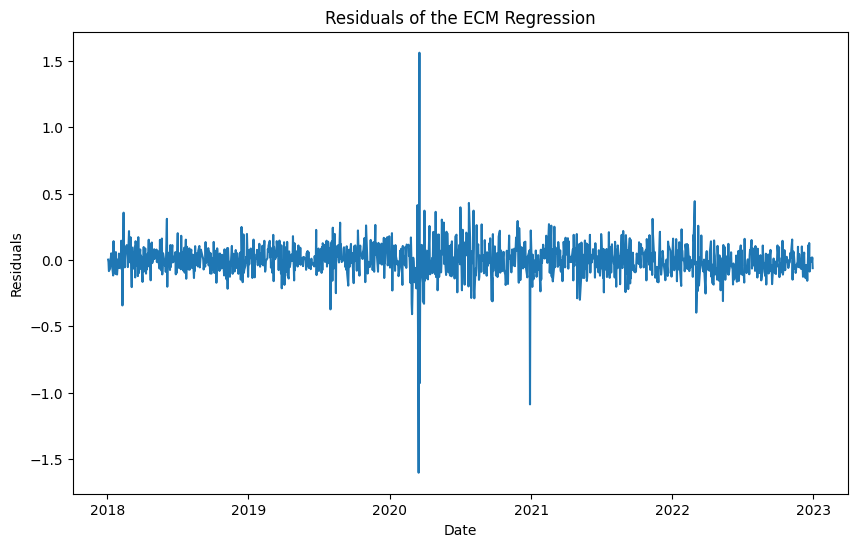

In [17]:
# Plot the residuals of the ECM regression
residuals_ecm = df_diff['GOAU'] - ecm_model.params['Delta_GDX'] *df_diff['GDX']-ecm_model.params['Lagged_GOAU']*lagged_goau - ecm_model.params['Lagged_GDX']*lagged_gdx-ecm_model.params['const']
plt.figure(figsize=(10, 6))
plt.plot(residuals_ecm)
plt.title('Residuals of the ECM Regression')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [18]:
# Calculation of autocorrelation of residuals for multiple lags
lags = 10
autocorr_residus_ecm_multi_lags = [residuals_ecm.autocorr(lag=i) for i in range(1, lags+1)]
print(f'Autocorrélation des résidus de l\'ECM pour les lags 1 à {lags} :')
print(autocorr_residus_ecm_multi_lags)

#This code calculates and prints the autocorrelation of the residuals of the Error Correction Model (ECM) for lags from 1 to 10.
#This provides information about the serial correlation of residuals at different lags in time.

Autocorrélation des résidus de l'ECM pour les lags 1 à 10 :
[-0.18272520904293887, -0.09614145186267373, 0.09382258835527002, 0.024147458361476883, 0.03840663795708614, 0.04112927194550613, 0.03345879475741374, -0.030060922814444453, 0.06677382406232642, -0.0002930976486303601]


### Non-cointegrated situation

>AAPL : Apple Inc
>
>MSFT : Microsoft Corp

In [19]:
# Download historical data for AAPL and MSFT
aapl = yf.download('AAPL', start='2018-01-01', end='2023-01-01')['Adj Close']
msft = yf.download('MSFT', start='2018-01-01', end='2023-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [29]:
data_stocks_2 = pd.DataFrame({"AAPL": gdx_data, "MSFT": goau_data})
#The line of code creates a DataFrame named 'stocks' using the pandas library, containing the time series data for the tickers 'AAPL' and 'MSFT' downloaded earlier.
#Each column of the DataFrame represents the corresponding closing adjustment prices for the two assets.

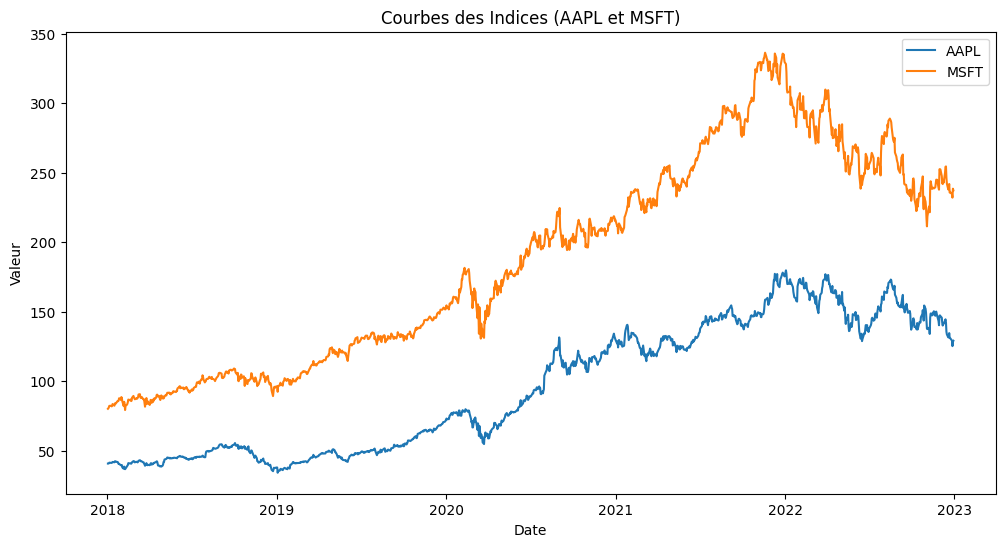

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(aapl, label='AAPL')
plt.plot(msft, label='MSFT')
plt.title('Courbes des Indices (AAPL et MSFT)')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [33]:
# Dickey-Fuller test for each index
for stock in data_stocks_2.columns:
    adf_statistic, adf_pvalue, _, _, _, _ = sm.tsa.adfuller(data_stocks_2[stock])
    print(f'\nTest de Dickey-Fuller pour {stock}:')
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {adf_pvalue}')
    print(f'Résultat du test de stationnarité: {"Stationnaire" if adf_pvalue < 0.05 else "Non stationnaire"}')
    
#This code performs a Dickey-Fuller test for each index present in the DataFrame 'data_stocks'.
#It then prints the test statistics, p-values, and indicates whether the time series is stationary or not based on the threshold of 0.05.


Test de Dickey-Fuller pour AAPL:
ADF Statistic: -1.9801315636706551
p-value: 0.29535208261923385
Résultat du test de stationnarité: Non stationnaire

Test de Dickey-Fuller pour MSFT:
ADF Statistic: -1.84849361868389
p-value: 0.35666534750253576
Résultat du test de stationnarité: Non stationnaire


In [35]:
# simple linear regression
X = sm.add_constant(data_stocks_2['AAPL'])
model = sm.OLS(data_stocks_2['MSFT'], X).fit()
print('\nRégression linéaire simple:')
print(model.summary())

#this code performs a simple linear regression using the Statsmodels library to fit a linear model between the data of Apple (AAPL) and Microsoft (MSFT) in the DataFrame data_stocks.
#it then prints the summary of the linear regression model, which includes information such as coefficients, test statistics, and p-values.


Régression linéaire simple:
                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 5.920e+04
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:41:53   Log-Likelihood:                -971.21
No. Observations:                1259   AIC:                             1946.
Df Residuals:                    1257   BIC:                             1957.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0393  

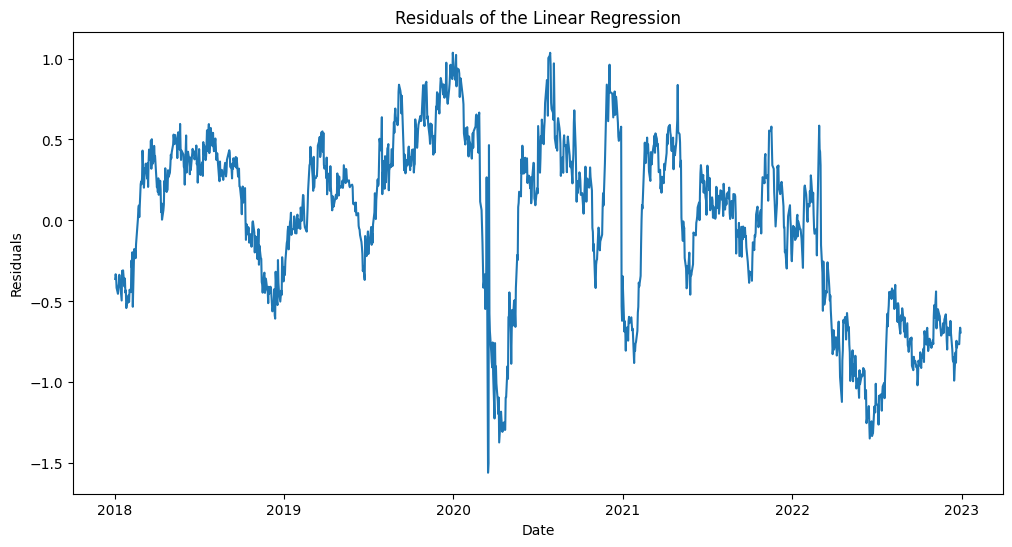

In [36]:
# analyse the residuals
residuals = data_stocks_2['MSFT'] - model.params['AAPL'] * data_stocks_2['AAPL'] - model.params['const']
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the Linear Regression')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

In [39]:
# Dickey-Fuller test for the residuals
adf_statistic_resid, adf_pvalue_resid, _, _, _, _ = sm.tsa.adfuller(residuals)
print("\nDickey-Fuller test for residuals of the simple linear regression:")
print(f"ADF Statistic: {adf_statistic_resid}")
print(f"p-value: {adf_pvalue_resid}")
print(
    f'Stationnarity test result: {"Stationary" if adf_pvalue_resid < 0.05 else "Non_Stationary"}'
)
# This code performs the Dickey-Fuller test for the residuals of the simple linear regression and prints the test result:
# including the ADF statistic, p-value, and verdict on the stationarity of the residuals.


Dickey-Fuller test for residuals of the simple linear regression:
ADF Statistic: -3.6093709437039907
p-value: 0.005584382006611514
Stationnarity test result: Stationary


                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     8206.
Date:                Wed, 20 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:44:38   Log-Likelihood:                -1.8339
No. Observations:                1258   AIC:                             7.668
Df Residuals:                    1256   BIC:                             17.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.007      0.081      0.9

C:\Users\HP\AppData\Local\Temp\ipykernel_24336\3253696025.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  residuals_diff = delta_y - differences_model.params[1] * delta_x


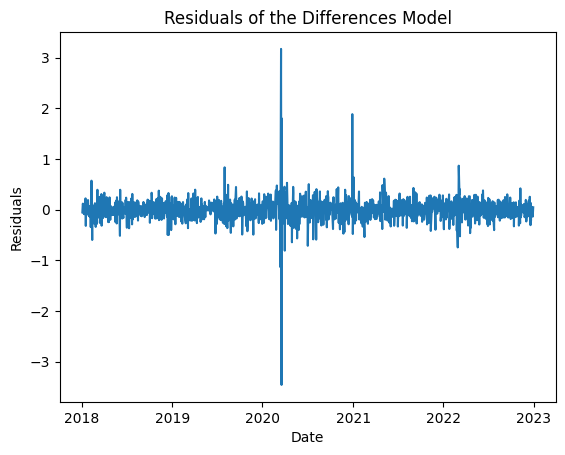


Dickey-Fuller Test for MSFT Differences:
ADF Statistic: -21.70633350832285
p-value: 0.0
Critical Values: {'1%': -3.435571295403709, '5%': -2.863845736356174, '10%': -2.567997600196822}
Result of Stationarity Test: Stationary

Dickey-Fuller Test for Residuals of Differences Regression:
ADF Statistic: -36.233391700463855
p-value: 0.0
Result of Stationarity Test: Stationary


In [40]:
#Modeling Differences
delta_y = data_stocks_2["AAPL"].diff().dropna()
delta_x = data_stocks_2["MSFT"].diff().dropna()

#Regression of Differences
differences_model = sm.OLS(delta_y, sm.add_constant(delta_x)).fit()

#Display the results of the regression of differences
print(differences_model.summary())

#Plot the residuals of the regression of differences
residuals_diff = delta_y - differences_model.params[1] * delta_x
plt.plot(residuals_diff)
plt.title("Residuals of the Differences Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

for stock in data_stocks_2.columns:
    adf_result = adfuller(data_stocks_2[stock].diff().dropna(), autolag="AIC")

print(f"\nDickey-Fuller Test for {stock} Differences:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")
print(
    f'Result of Stationarity Test: {"Stationary" if adf_result[1] < 0.05 else "Non-stationary"}'
)

#Dickey-Fuller Test for the residuals of the differences regression
adf_statistic_diff, adf_pvalue_diff, _, _, _, _ = sm.tsa.adfuller(residuals_diff)
print("\nDickey-Fuller Test for Residuals of Differences Regression:")
print(f"ADF Statistic: {adf_statistic_diff}")
print(f"p-value: {adf_pvalue_diff}")
print(
f'Result of Stationarity Test: {"Stationary" if adf_pvalue_diff < 0.05 else "Non-stationary"}'
)

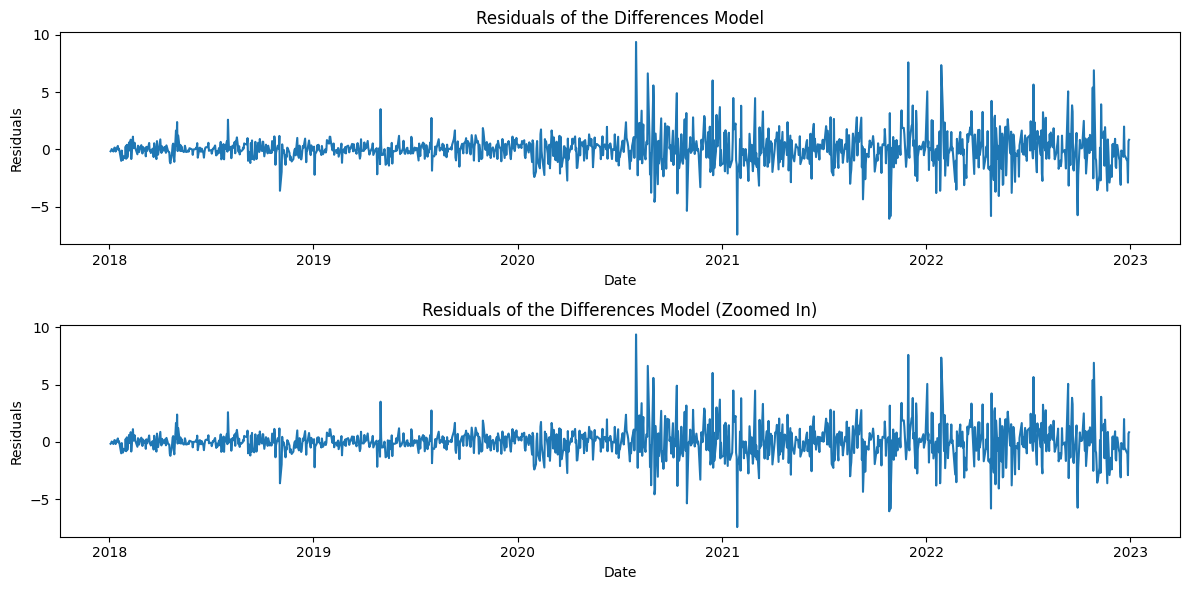

In [ ]:
# Plot the residuals of the differences regression.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals_diff)
plt.title("Residuals of the Differences Model")
plt.xlabel("Date")
plt.ylabel("Residuals")

# Dickey-Fuller test for the residuals of the differences regression
plt.subplot(2, 1, 2)
plt.plot(data_stocks.index[1:], residuals_diff)
plt.title("Residuals of the Differences Model (Zoomed In)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()